# **Imports and setup**

The notebook can be run in Google Colab, because the local machine had no GPU. Requirements can be found in requirements.txt

In [2]:
pip install -U yfinance pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 47.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 2.2.2 which is incompatible.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 2.2.2 which is incompatible.


In [3]:
import pandas as pd
import numpy as np

from scipy.optimize import fmin
from scipy.special import lambertw
from scipy.stats import kurtosis, norm

import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from tqdm import tqdm
import yfinance as yf
import random

%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
random.seed(42)
torch.manual_seed(42)

In [4]:
# Get the data for SP500 from May 2009 till Dec 2018 (as in the original paper)
sp500 = yf.download('^GSPC','2009-05-01','2018-12-31')

[*********************100%%**********************]  1 of 1 completed


## **Preprocessing**

In [5]:
sp500log = np.log(sp500['Close'] / sp500['Close'].shift(1))[1:].values

We see thick tails of distribution:

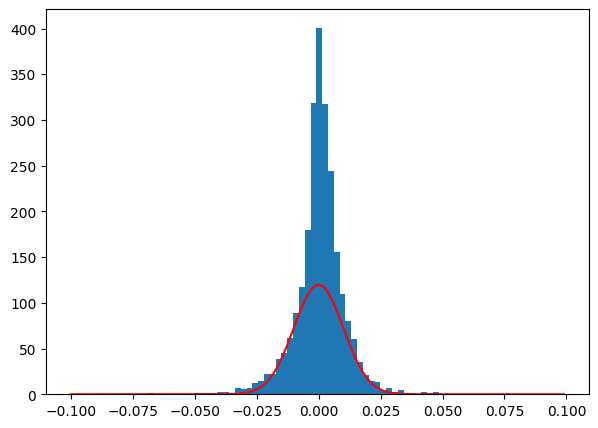

In [6]:
plt.hist(sp500log, bins=50)
x_axis = np.arange(-0.1, 0.1, 0.001)
plt.plot(x_axis, norm.pdf(x_axis, 0, 0.01) * 3, color= 'r')
plt.show()

Perform an inverse Lambert transformation and re-normalization using IGMM algorithm.


In [7]:
def delta_init(z):
    k = kurtosis(z, fisher=False, bias=False)
    if k < 166. / 62.:
        return 0.01
    return np.clip(1. / 66 * (np.sqrt(66 * k - 162.) - 6.), 0.01, 0.48)

def delta_gmm(z):
    delta = delta_init(z)

    def iter(q):
        u = W_delta(z, np.exp(q))
        if not np.all(np.isfinite(u)):
            return 0.
        k = kurtosis(u, fisher=True, bias=False)**2
        if not np.isfinite(k) or k > 1e10:
            return 1e10
        return k

    res = fmin(iter, np.log(delta), disp=0)
    return np.around(np.exp(res[-1]), 6)

def W_delta(z, delta):
    return np.sign(z) * np.sqrt(np.real(lambertw(delta * z ** 2)) / delta)

def W_params(z, params):
    return params[0] + params[1] * W_delta((z - params[0]) / params[1], params[2])

def inverse(z, params):
    return params[0] + params[1] * (z * np.exp(z * z * (params[2] * 0.5)))

def igmm(z, eps=1e-6, max_iter=100):
    delta = delta_init(z)
    params = [np.median(z), np.std(z) * (1. - 2. * delta) ** 0.75, delta]
    for k in range(max_iter):
        params_old = params
        u = (z - params[0]) / params[1]
        params[2] = delta_gmm(u)
        x = W_params(z, params)
        params[0], params[1] = np.mean(x), np.std(x)

        if np.linalg.norm(np.array(params) - np.array(params_old)) < eps:
            break
        if k == max_iter - 1:
            raise "Solution not found"

    return params

sp500log_mean = np.mean(sp500log)
sp500log_norm = sp500log - sp500log_mean
params = igmm(sp500log_norm)
sp500processed = W_delta((sp500log_norm - params[0]) / params[1], params[2])
sp500max = np.max(np.abs(sp500processed))
sp500processed /= sp500max

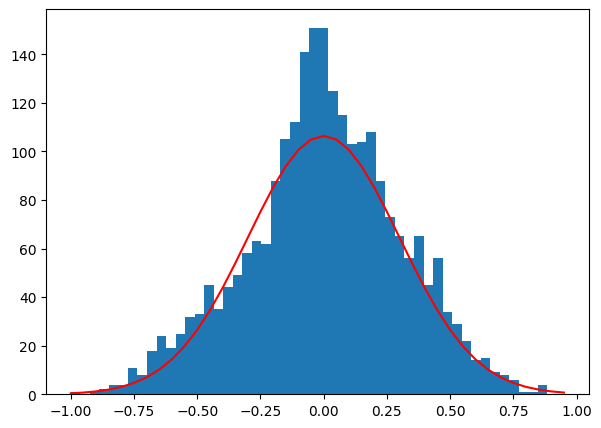

In [8]:
plt.hist(sp500processed, bins=50)
x_axis = np.arange(-1, 1, 0.05)
plt.plot(x_axis, norm.pdf(x_axis, 0, 0.3) * 80, color= 'r')
plt.show()

In [9]:
# Dataset

class SP500Dataset(Dataset):
    def __init__(self, data, window):
        self.data = data
        self.window = window

    def __getitem__(self, index):
        x = np.expand_dims(self.data[index:index+self.window], -1)
        return torch.from_numpy(x).float()

    def __len__(self):
        return len(self.data) - self.window

# **Models for GAN**

In [10]:
class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_outputs, kernel_size, dilation):
        super(TemporalBlock, self).__init__()
        self.conv1 = nn.Conv1d(n_inputs, n_hidden, kernel_size, stride=1, dilation=dilation, padding='same')

        self.relu1 = nn.PReLU()
        self.conv2 = nn.Conv1d(n_hidden, n_outputs, kernel_size, stride=1, dilation=dilation, padding='same')
        self.relu2 = nn.PReLU()

        self.net = nn.Sequential(self.conv1, self.relu1, self.conv2, self.relu2)

        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None

        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return out + res

class TCN(nn.Module):
    def __init__(self, input_size, output_size, n_hidden=80):
        super(TCN, self).__init__()
        layers = []
        for i in range(7):
            num_inputs = input_size if i == 0 else n_hidden
            kernel_size = 2 if i > 0 else 1
            dilation = 2 * dilation if i > 1 else 1
            layers += [TemporalBlock(num_inputs, n_hidden, n_hidden, kernel_size, dilation)]
        self.conv = nn.Conv1d(n_hidden, output_size, 1)
        self.net = nn.Sequential(*layers)
        self.init_weights()

    def init_weights(self):
        self.conv.weight.data.normal_(0, 0.01)

    def forward(self, x):
        y1 = self.net(x.transpose(1, 2))
        return self.conv(y1).transpose(1, 2)

class Generator(nn.Module):
    def __init__(self, input_size, output_size):
        super(Generator, self).__init__()
        self.net = TCN(input_size, output_size)

    def forward(self, x):
        return torch.tanh(self.net(x))

class Discriminator(nn.Module):
    def __init__(self, input_size, output_size):
        super(Discriminator, self).__init__()
        self.net = TCN(input_size, output_size)

    def forward(self, x):
        return torch.sigmoid(self.net(x))

# **Prepare and train GAN**

In [11]:
clip_value = 0.01
lr = 0.0002
num_epochs = 50
nz = 3
batch_size = 30
seq_len = 127

netG = Generator(nz, 1).to(device)
netD = Discriminator(1, 1).to(device)
optD = optim.RMSprop(netD.parameters(), lr=lr)
optG = optim.RMSprop(netG.parameters(), lr=lr)

dataset = SP500Dataset(sp500processed, 127)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
t = tqdm(range(num_epochs))
for epoch in t:
    for i, data in enumerate(dataloader, 0):

        netD.zero_grad()
        real = data.to(device)
        batch_size, seq_len = real.size(0), real.size(1)
        noise = torch.randn(batch_size, seq_len, nz, device=device)
        fake = netG(noise).detach()

        lossD = -torch.mean(netD(real)) + torch.mean(netD(fake))
        lossD.backward()
        optD.step()

        for p in netD.parameters():
            p.data.clamp_(-clip_value, clip_value)

        if i % 5 == 0:
            netG.zero_grad()
            lossG = -torch.mean(netD(netG(noise)))
            lossG.backward()
            optG.step()
    #Report metrics
    t.set_description('Loss_D: %.8f Loss_G: %.8f' % (lossD.item(), lossG.item()))

    # Checkpoint
    torch.save(netG, 'sp500_netG_epoch_%d.pth' % epoch)
    torch.save(netD, 'sp500_netD_epoch_%d.pth' % epoch)


  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv1d(input, weight, bias, self.stride,
Loss_D: 0.00000250 Loss_G: -0.50632548: 100%|██████████| 50/50 [01:10<00:00,  1.41s/it]


#**Probe generation**

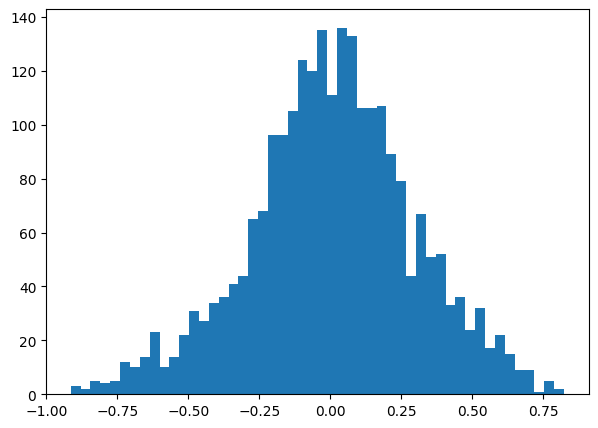

In [15]:
noise = torch.randn(1, 2432, 3, device=device)
fake = netG(noise).detach().cpu().reshape(2432).numpy()
plt.hist(fake, bins=50)
plt.show()

Now we revert preprocessing steps to get a simulated trajectory.

In [16]:
sp500fake = inverse(fake * sp500max, params)

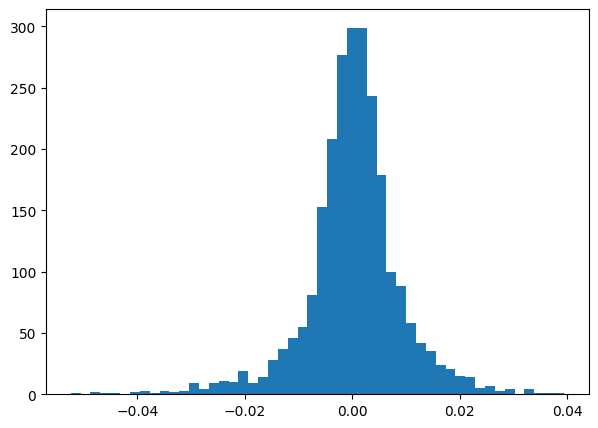

In [17]:
plt.hist(sp500fake, bins=50)
plt.show()

## Visualize results

In [18]:
def generate_fakes(n=1, cumsum=True):
  fakes = []
  for i in range(n):
    noise = torch.randn(1, 2432, 3, device=device)
    fake = netG(noise).detach().cpu().reshape(2432).numpy()
    sp500fake = inverse(fake * sp500max, params) + sp500log_mean
    fakes.append(sp500fake)
  if n > 1:
    if not cumsum:
      return pd.DataFrame(fakes).T
    fakes_df = pd.DataFrame(fakes).T.cumsum()
    return fakes_df
  elif not cumsum:
    return sp500fake
  return sp500fake.cumsum()

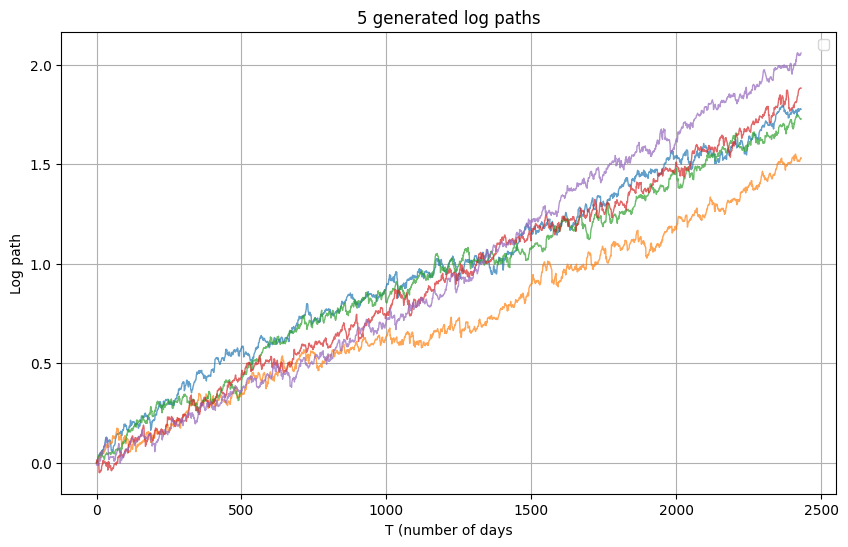

In [19]:
plt.figure(figsize=(10,6))
plt.plot(generate_fakes(5), linewidth=1, alpha=0.7)
plt.legend('')
plt.grid(True)
plt.xlabel('T (number of days')
plt.ylabel('Log path')
plt.title('5 generated log paths');

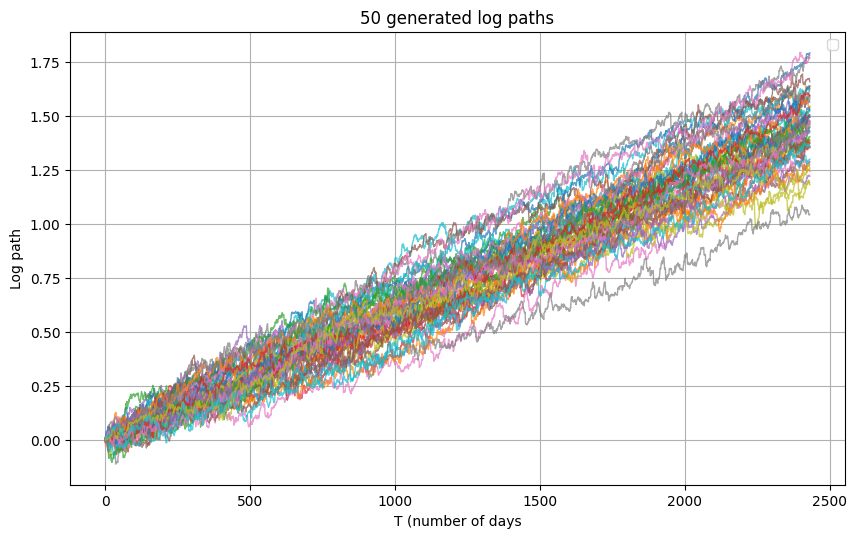

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(generate_fakes(50), linewidth=1, alpha=0.7)
plt.legend('')
plt.grid(True)
plt.xlabel('T (number of days')
plt.ylabel('Log path')
plt.title('50 generated log paths');

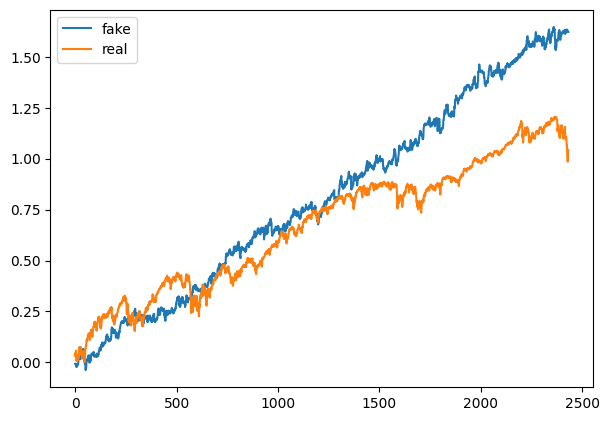

In [ ]:
comp_df = pd.DataFrame({'fake': generate_fakes(), 'real': sp500log.cumsum()})
comp_df.plot()

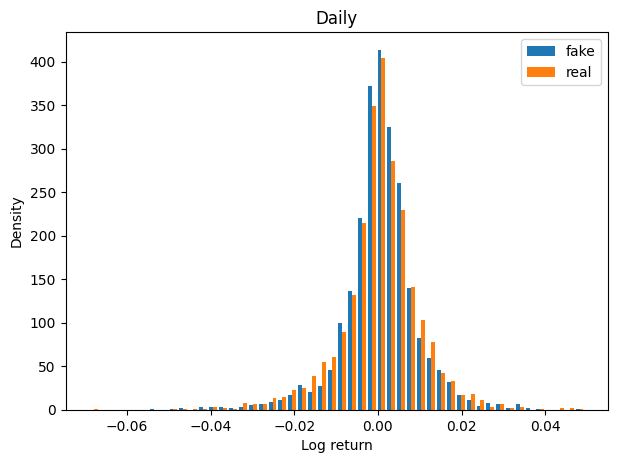

In [ ]:
plt.hist([comp_df['fake'].diff(), comp_df['real'].diff()], bins=50, label=['fake', 'real'])
plt.legend(loc='upper right')
plt.xlabel('Log return')
plt.ylabel('Density')
plt.title('Daily')
plt.show()

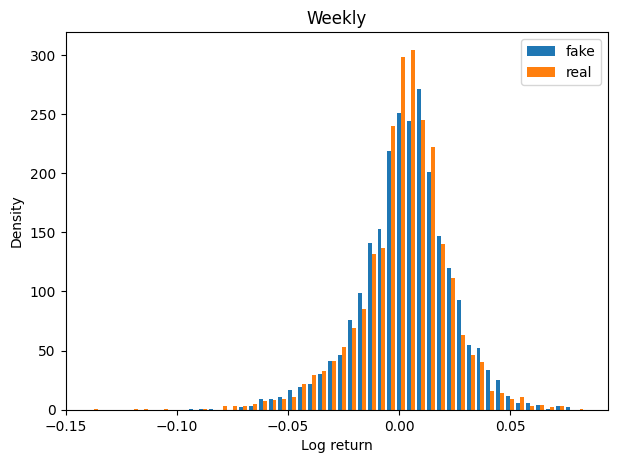

In [ ]:
plt.hist([comp_df['fake'].diff(5), comp_df['real'].diff(5)], bins=50, label=['fake', 'real'])
plt.legend(loc='upper right')
plt.xlabel('Log return')
plt.ylabel('Density')
plt.title('Weekly')
plt.show()

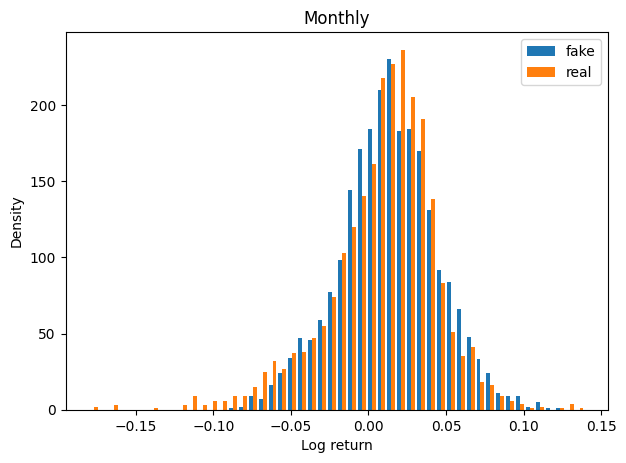

In [ ]:
plt.hist([comp_df['fake'].diff(20), comp_df['real'].diff(20)], bins=50, label=['fake', 'real'])
plt.legend(loc='upper right')
plt.xlabel('Log return')
plt.ylabel('Density')
plt.title('Monthly')
plt.show()

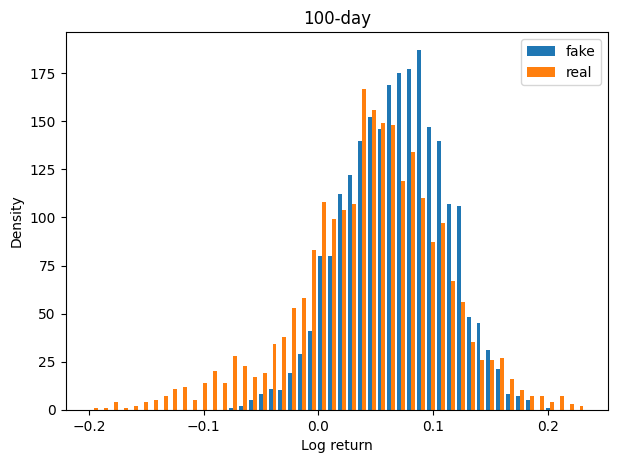

In [ ]:
plt.hist([comp_df['fake'].diff(100), comp_df['real'].diff(100)], bins=50, label=['fake', 'real'])
plt.legend(loc='upper right')
plt.xlabel('Log return')
plt.ylabel('Density')
plt.title('100-day')
plt.show()

In [ ]:
def autocorr(x, n=50):
  if len(x.shape) > 1:
    x = x.mean(axis=1)
  result = np.correlate(x, x, mode='full')
  return pd.DataFrame(result[result.size//2:][:n])

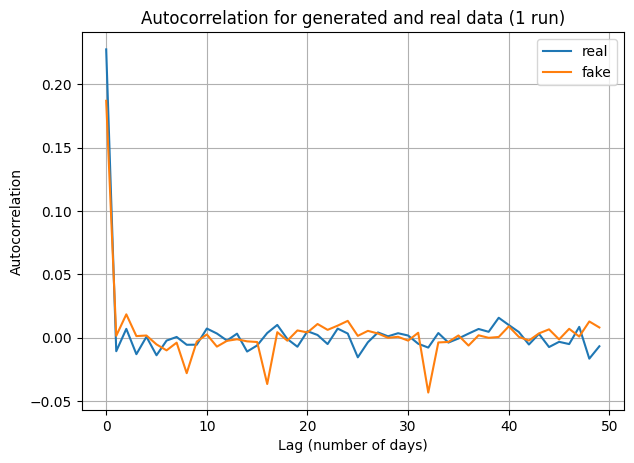

In [ ]:
fakes = generate_fakes(cumsum=False)
correlations_normal_real = autocorr(sp500log)
correlations_normal_fake = autocorr(fakes)

plt.plot(correlations_normal_real, label='real')
plt.plot(correlations_normal_fake, label='fake')
plt.grid(True)
plt.legend()
plt.title('Autocorrelation for generated and real data (1 run)')
plt.xlabel('Lag (number of days)')
plt.ylabel('Autocorrelation')
plt.show()

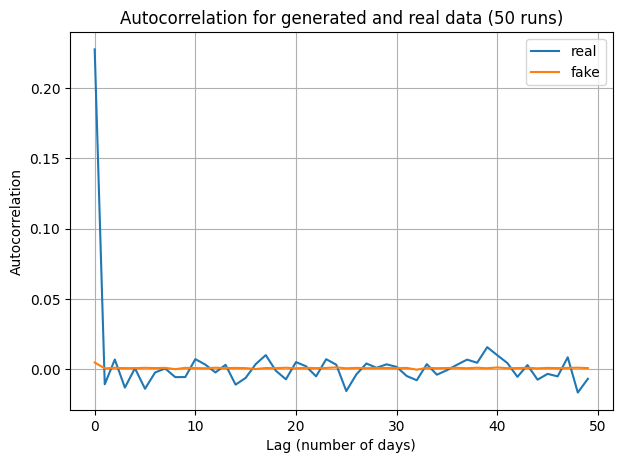

In [ ]:
fakes = generate_fakes(50, cumsum=False)
correlations_normal_real = autocorr(sp500log)
correlations_normal_fake = autocorr(fakes)

plt.plot(correlations_normal_real, label='real')
plt.plot(correlations_normal_fake, label='fake')
plt.grid(True)
plt.legend()
plt.title('Autocorrelation for generated and real data (50 runs)')
plt.xlabel('Lag (number of days)')
plt.ylabel('Autocorrelation')
plt.show()

In [ ]:
#!pip freeze > requirements.txt